# Problem Statement


## Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# Imports & Data Loading

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import  roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read the data
cust = pd.read_csv("data/telecom_churn_data.csv")

In [4]:
cust.shape

(99999, 226)

In [5]:
cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [6]:
# Smaller file to manually check on the first 10 records in the dataset
cust.head(10).T.to_csv("sample_10_T.csv")

In [7]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Utility Methods

## Check for missing values in a dataframe

In [8]:
# Check for missing values in the dataframe and print them
def print_missing_columns(input_df):
    # Print missing percentage of only columns with missing values
    missing_columns = input_df.columns[input_df.isnull().any()]
    if not missing_columns.empty:
        missing_count = input_df[missing_columns].isnull().sum()
        missing_col_type = pd.Series([type(col) for col in input_df[missing_columns]],index = missing_columns) 
        unique_count = input_df[missing_columns].nunique()

        missing_df = pd.concat({
                        "Missing": missing_count, 
                        "Missing %": missing_count/len(input_df.index)*100,
                        #"Type": missing_col_type,
                        "Unique Count": unique_count
                       } , 
                       axis = 1).sort_values(by = 'Missing', ascending = False)

        display(missing_df)
    else:
        display("NO MISSING VALUES IN THE DATAFRAME")

# Data Preprocessing

## <TODO> Check data types

In [9]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


Date columns are present as objects. Convert to datetime type.

In [10]:
# Change data type of date columns to datetime
date_cols = [col for col in cust.columns if re.match('^date|^last_date', col)]
cust[date_cols] = cust[date_cols].apply(pd.to_datetime,errors='coerce') 

## Check for missing data

In [11]:
print_missing_columns(cust)

,Missing,Missing %,Unique Count
count_rech_2g_6,74846,74.846748,31
max_rech_data_6,74846,74.846748,48
arpu_3g_6,74846,74.846748,7418
av_rech_amt_data_6,74846,74.846748,887
count_rech_3g_6,74846,74.846748,25
night_pck_user_6,74846,74.846748,2
arpu_2g_6,74846,74.846748,6990
fb_user_6,74846,74.846748,2
total_rech_data_6,74846,74.846748,37
date_of_last_rech_data_6,74846,74.846748,30


## Handle missing data

### Replace missing with 0
- Missing 'incoming' & 'outgoing' call related columns can be set to 0 assuming there were no calls received/made for that column type
- Recharge related columns can be set to 0 assuming empty cells indicate no recharge was done in that month
- Minutes of Usage (MoU) and average revenue per user (arpu) columns are also handled similarly 

In [12]:
cust.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [13]:
# Incoming calls column:
# All columns with incoming call information have the string "ic_" in the column name
# Fill the missing values in these columns with 0
incoming_cols = [col for col in cust.columns if 'ic_' in col]
cust[incoming_cols] = cust[incoming_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(incoming_cols)} incoming columns:{incoming_cols}')

# Outgoing calls column:
# All columns with outgoing call information have the string "og_" in the column name
# Fill the missing values in these columns with 0
outcoming_cols = [col for col in cust.columns if 'og_' in col]
cust[outcoming_cols] = cust[outcoming_cols].fillna(0)
print(f'\nReplaced missing values with 0 for {len(outcoming_cols)} outgoing columns:{outcoming_cols}')

Replaced missing values with 0 for 57 incoming columns:['loc_ic_t2o_mou', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'std_ic_mou_9', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'spl_ic_mou_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'i

In [14]:
# Recharge related columns
rech_cols = [col for col in cust.columns if re.match('^count_rech_|^max_rech_|^total_rech_|^av_rech_', col)]
cust[rech_cols] = cust[rech_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(rech_cols)} recharge columns :{rech_cols}')

Replaced missing values with 0 for 32 recharge columns :['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [15]:
# arpu related columns
arpu_cols = [col for col in cust.columns if re.match('^arpu', col)]
cust[arpu_cols] = cust[arpu_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(arpu_cols)} arpu columns :{arpu_cols}')

Replaced missing values with 0 for 12 arpu columns :['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9']


### Handle date columns

- Last recharges made for talktime and data for each month is provided in the input data<br>
- With this information, we will create a new derived column which has the number of days since the last recharge <br>
- Combine the columns for the good phase & action phase (months 6, 7 & 8) and get the latest date when a recharge was made <br>
- At the beginning of 9th month, get the number of days since the last recharge <br>
<br>
Hypothesis - if the customer has done a recharge recently, they are less likely to churn.  <br>

In [16]:
print(f'Shape before handling date columns:{cust.shape}')

Shape before handling date columns:(99999, 226)


In [17]:
date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9']

In [18]:
cust[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']].tail()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
99994,2014-06-03,2014-07-20,2014-08-26
99995,2014-06-17,2014-07-17,2014-08-24
99996,2014-06-13,2014-07-26,NaT
99997,2014-06-17,2014-07-19,2014-08-20
99998,2014-06-16,NaT,NaT


In [ ]:
# Find the last recharge date in the good phase & action phase (gaphase) together (Months 6,7,8)
last_rech_date_cols = [col for col in cust.columns if re.match('^date_of_last_.*[_6|_7|_8]$', col)]
cust['last_rech_date_gaphase'] = cust[last_rech_date_cols].apply(lambda x: x.max(),axis=1)

In [ ]:
# Check for missing values
cust['last_rech_date_gaphase'].isnull().sum()

99

In [ ]:
# Missing values in this new column implies no recharge has happend in the 3 months.
# Fill missing value with last date of previous month before the start of good phase
last_rech_date_missing = datetime.datetime(2014, 5, 31)
cust['last_rech_date_gaphase']=cust['last_rech_date_gaphase'].fillna(last_rech_date_missing)

In [ ]:
# Create column for number of  days since last recharge
last_date_action_phase = datetime.datetime(2014, 8, 31)
cust['last_rech_num_days'] = (last_date_action_phase - cust['last_rech_date_gaphase']).dt.days

In [ ]:
cust[['last_rech_date_gaphase','last_rech_num_days']].head()

,last_rech_date_gaphase,last_rech_num_days
0,2014-08-08,23
1,2014-08-28,3
2,2014-08-14,17
3,2014-08-31,0
4,2014-08-09,22


In [ ]:
# drop date columns after creating the days columns
print(f'Shape before dropping date columns:{cust.shape}')
cust.drop(date_cols,inplace=True,axis=1)
cust.drop('last_rech_date_gaphase',inplace=True,axis=1)
print(f'Shape after dropping date columns:{cust.shape}')

Shape before dropping date columns:(99999, 228)
Shape after dropping date columns:(99999, 215)


In [ ]:
print_missing_columns(cust)

,Missing,Missing %,Unique Count
night_pck_user_6,74846,74.846748,2
fb_user_6,74846,74.846748,2
night_pck_user_7,74428,74.428744,2
fb_user_7,74428,74.428744,2
night_pck_user_9,74077,74.077741,2
fb_user_9,74077,74.077741,2
night_pck_user_8,73660,73.660737,2
fb_user_8,73660,73.660737,2
onnet_mou_9,7745,7.745077,23565
offnet_mou_9,7745,7.745077,30077


The remaining missing values are filled using the IterativeImputer in sklearn

### Replace binary category values with mode

In [ ]:
# Fill the remaining categorical columns with mode
fb_night_cols = [col for col in cust.columns if re.match('^fb_user_|^night_pck_user_', col)]
for col in fb_night_cols:
    cust[col].fillna(cust[col].mode()[0],inplace=True)

### IterativeImputer

In [ ]:
# Use iterative imputer to fill the rest of the missing colums (fOFFNET/ONNET MOU columns)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imputer = IterativeImputer()

# OFFNET/ONNET MOU related columns
mou_cols = [col for col in cust.columns if re.match('^onnet_mou|^offnet_mou', col)]
cust[mou_cols] = iter_imputer.fit_transform(cust[mou_cols])

In [ ]:
print_missing_columns(cust)

'NO MISSING VALUES IN THE DATAFRAME'

## Check & Treat for outliers

In [ ]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days
count,9.999900e+04,99999.0,99999.0,99999.0,99999.0,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,...,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,131.988197,...,0.978470,0.976670,0.971240,0.963960,1219.854749,68.170248,66.839062,60.021204,3.299373,7.148231
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,293.704269,...,0.145144,0.150951,0.167133,0.186392,954.733842,267.580450,271.201856,253.938223,32.408353,10.683080
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,-44.674940,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,7.000025e+09,109.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,7.000122e+09,109.0,0.0,0.0,0.0,1.500000,0.750000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,7.000244e+09,109.0,0.0,0.0,0.0,31.647200,29.355800,18.054200,0.090000,0.350000,...,1.000000,1.000000,1.000000,1.000000,286.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,8.030000,...,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,36.640000,...,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,123.340000,...,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000,7.000000


**NOTE on outliers:** 
- Almost all the columns have outliers in the last one percentile.  
- It requires more domain knowledge to understand on how the outliers should be treated.  
- Some options to treat the outliers:  
    1. Remove rows above the upper cap (could be 99% in this case)
    2. Cap the values in the last percentile to 99%
    3. Don't modify the data if it is expected 
- In this case study, we will check on the arpu columns and remove the outliers in these variables  
 

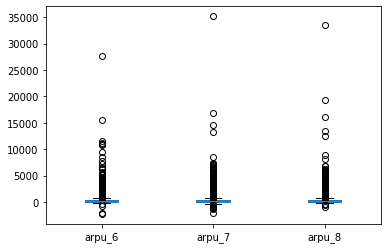

In [ ]:
cust[['arpu_6','arpu_7','arpu_8']].plot.box()

In [ ]:
# Drop outliers with a cap of 99% on the arpu columns
columns_outliers = ['arpu_6','arpu_7','arpu_8']

cap_arpu_6 = cust['arpu_6'].quantile(.99)
cap_arpu_7 = cust['arpu_7'].quantile(.99)
cap_arpu_8 = cust['arpu_8'].quantile(.99)
cust =  cust[(cust['arpu_6'] <= cap_arpu_6) & (cust['arpu_7'] <= cap_arpu_7) & (cust['arpu_8'] <= cap_arpu_8)] 


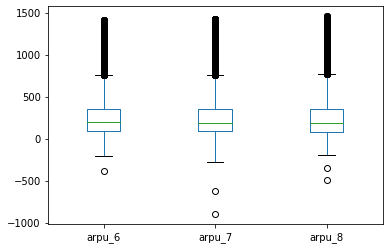

In [ ]:
cust[['arpu_6','arpu_7','arpu_8']].plot.box()

In [ ]:
cust.shape

(98041, 215)

In [ ]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days
count,9.804100e+04,98041.0,98041.0,98041.0,98041.0,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,...,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,260.320312,254.611844,255.664261,242.988043,122.938500,...,0.978723,0.976877,0.971665,0.964270,1220.918728,62.048232,60.696221,54.210008,2.923780,7.202079
std,6.958365e+05,0.0,0.0,0.0,0.0,236.731151,236.088674,241.455939,253.622200,256.755997,...,0.144306,0.150295,0.165929,0.185617,955.345362,235.716288,240.844109,223.625920,29.167377,10.711587
min,7.000000e+09,109.0,0.0,0.0,0.0,-383.565000,-897.035000,-491.545000,-1474.195000,-44.674940,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,7.000025e+09,109.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,7.000122e+09,109.0,0.0,0.0,0.0,1.350000,0.690000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,7.000244e+09,109.0,0.0,0.0,0.0,31.000000,28.510000,17.749000,0.070000,0.310000,...,1.000000,1.000000,1.000000,1.000000,286.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,91.855000,85.519000,82.788000,61.719000,7.830000,...,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.001204e+09,109.0,0.0,0.0,0.0,193.467000,187.268000,187.879000,173.205000,35.490000,...,1.000000,1.000000,1.000000,1.000000,865.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,357.983000,352.190000,356.587000,342.214000,118.580000,...,1.000000,1.000000,1.000000,1.000000,1811.000000,0.000000,0.000000,0.000000,0.000000,7.000000


## Remove columns with only one unique value. 
Columns with only one unique value will not add much value to the analysis and can be removed

In [ ]:
cust = cust[[col for col in cust.columns if cust[col].nunique() > 1]]


## Drop ID column - mobile_number

In [ ]:
cust.drop(['mobile_number'],axis=1,inplace=True)

In [ ]:
cust.shape

(98041, 202)

In [ ]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98041 entries, 0 to 99998
Columns: 202 entries, arpu_6 to last_rech_num_days
dtypes: float64(168), int64(34)
memory usage: 151.8 MB


In [ ]:
print_missing_columns(cust)

'NO MISSING VALUES IN THE DATAFRAME'

# Target Variable Creation

## Create Target variable from 9th Month

Create the target variable based on the below rule:
 
Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9,
total_og_mou_9,
vol_2g_mb_9,
vol_3g_mb_9

In [ ]:
# Create churn flag based on the 9th month variables. 
cust['churn'] = (cust['total_ic_mou_9']+cust['total_og_mou_9']+cust['vol_2g_mb_9']+cust['vol_3g_mb_9']) == 0
cust['churn']=cust['churn'].map({True:1,False:0})

In [ ]:
cust['churn'].value_counts()

0    88102
1     9939
Name: churn, dtype: int64

## Remove 9th month variables

In [ ]:
# drop the columns with the suffix _9, they should not be used while training the model.

print(f'Shape before dropping 9th month columns:{cust.shape}')
month_9_cols = [col for col in cust.columns if re.search('_9$', col)]
cust.drop(month_9_cols,inplace=True,axis=1)
print(f'Shape after dropping 9th month columns:{cust.shape}')

Shape before dropping 9th month columns:(98041, 203)
Shape after dropping 9th month columns:(98041, 154)


Remove the 9th month variables after creating the target variables. Would otherwise lead to data leakage.

# Identify High Value Customers

We need to predict churn only for the high-value customers. <br>
Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

## Find average of M6,M7

In [ ]:
cust.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days,churn
0,197.385,214.816,213.803,53.070302,27.480769,0.00,81.437483,44.940882,0.00,0.0,...,1.0,1.0,1.0,968,30.4,0.0,101.20,3.58,23,1
1,34.047,355.074,268.321,24.110000,78.680000,7.68,15.740000,99.840000,304.76,0.0,...,1.0,1.0,1.0,1006,0.0,0.0,0.00,0.00,3,0
2,167.690,189.058,210.226,11.540000,55.240000,37.26,143.330000,220.590000,208.36,0.0,...,1.0,1.0,1.0,1103,0.0,0.0,4.17,0.00,17,0
3,221.338,251.102,508.054,99.910000,54.390000,310.98,123.310000,109.010000,71.68,0.0,...,1.0,1.0,1.0,2491,0.0,0.0,0.00,0.00,0,0
4,261.636,309.876,238.174,50.310000,149.440000,83.89,76.960000,91.880000,124.26,0.0,...,0.0,1.0,1.0,1526,0.0,0.0,0.00,0.00,22,0


In [ ]:
m6_cols = [col for col in cust.columns if re.search('.*rech.*_6$' , col)]
cust[m6_cols].head()


,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6
0,4,362,252,1.0,252.0,0.0,1.0,252.0
1,4,74,44,0.0,0.0,0.0,0.0,0.0
2,5,168,86,0.0,0.0,0.0,0.0,0.0
3,10,230,60,0.0,0.0,0.0,0.0,0.0
4,5,196,56,1.0,56.0,1.0,0.0,56.0


In [ ]:
# Check if total recharge data column is same as sum of no. of recharges in 2G & 3G
print(cust[cust['total_rech_data_6'] != (cust['count_rech_2g_6']+cust['count_rech_3g_6'])].empty)
print(cust[cust['total_rech_data_7'] != (cust['count_rech_2g_7']+cust['count_rech_3g_7'])].empty)

True
True


<b>Assumption:</b> total_rech_amt_* column is only for the talktime recharge and not for data recharge <br>
This information is not clear in the data dictionary and requires domain knowledge. <br>
We can compute the total rech amount for a month as sum of (talktime recharge + data recharge)

In [ ]:
cust['avg_rech_amt_6_7'] = ((cust['total_rech_amt_6'] + cust['total_rech_data_6']*cust['av_rech_amt_data_6']) +
                            (cust['total_rech_amt_7'] + cust['total_rech_data_7']*cust['av_rech_amt_data_7']))/2

In [ ]:
cust[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_amt_7','avg_rech_amt_6_7']].tail()

,total_rech_amt_6,total_rech_data_6,av_rech_amt_data_6,total_rech_data_7,av_rech_amt_data_7,total_rech_amt_7,avg_rech_amt_6_7
99994,60,0.0,0.0,0.0,0.0,110,85.0
99995,110,0.0,0.0,0.0,0.0,110,110.0
99996,119,2.0,39.0,0.0,0.0,0,98.5
99997,381,3.0,583.0,2.0,358.0,358,1602.0
99998,710,1.0,154.0,0.0,0.0,0,432.0


Manually computing the average recharge amount looks to be correct. <br>
We can now identify the value at the 70th percentile to identify the High Value Customers

## Identify value at 70th percentile

In [ ]:
cust[['avg_rech_amt_6_7']].describe(percentiles=[0.1,0.3,0.5,0.7,0.9])

,avg_rech_amt_6_7
count,98041.000000
mean,441.626129
std,675.546034
min,0.000000
10%,60.000000
30%,151.500000
50%,270.000000
70%,458.500000
90%,944.000000
max,29185.500000


In [ ]:
avg_70 = cust[['avg_rech_amt_6_7']].quantile(0.7)[0]
print(f'Value at 70th percentile:{avg_70}')

Value at 70th percentile:458.5


## Flag high value customers

In [ ]:
cust['is_hvc'] = cust['avg_rech_amt_6_7'].apply(lambda x: int(x>= avg_70))

In [ ]:
cust['is_hvc'].value_counts()

0    68627
1    29414
Name: is_hvc, dtype: int64

## Filter data for high value customers

In [ ]:
# create a backup before filtering for high value customers
cust_orig = cust.copy()

In [ ]:
# Consider only high value customers for the model creation
cust = cust[cust['is_hvc'] == 1]

In [ ]:
cust.shape

(29414, 156)

In [ ]:
# drop the is_hvc flag column as we have considered only HVCs
cust.drop(['is_hvc'],axis=1,inplace=True)

# Define Variables

In [ ]:
DEPENDENT_VARIABLE = 'churn'

# Select numeric columns for EDA
m8_toc_cols = ['loc_og_t2c_mou_8'] # Outgoing calls to call center
aon_cols = ['aon'] # Age on number
mou_cols = [col for col in cust.columns if re.search('^total_.*mou.*' , col)] # Total minutes of usage
arpu_cols = [col for col in cust.columns if re.search('^arpu_.*' , col)] # Average revenue per user

CONTINUOUS_VAR_TO_ANALYSE = m8_toc_cols+aon_cols+mou_cols+arpu_cols

# Select categorical columns for EDA
BINARY_CATEGORICAL_VARIABLES = [col for col in cust.columns if re.match('^fb_user_|^night_pck_user_', col)]

In [ ]:
cust[CONTINUOUS_VAR_TO_ANALYSE].head()

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8
0,0.00,968,0.00,0.00,0.00,0.00,0.00,5.44,197.385,214.816,213.803,212.17,212.17,212.17,212.17,212.17,212.17
8,7.15,315,508.36,431.66,171.56,103.86,28.49,16.54,378.721,492.223,137.362,0.00,0.00,19.83,0.00,0.00,0.00
16,0.00,511,346.81,286.01,233.38,364.86,381.56,294.46,430.975,299.869,187.894,0.00,0.00,0.00,0.00,0.00,0.00
21,0.00,720,860.34,1028.79,1068.54,207.09,131.89,261.04,514.453,597.753,637.760,0.00,0.00,0.00,0.00,0.00,0.00
23,17.71,604,134.38,140.04,239.48,119.58,222.89,298.33,74.350,193.897,366.966,0.00,306.57,197.27,0.00,301.78,150.67


# EDA

## Target variable analysis

In [ ]:
cust['churn'].isnull().sum()

0

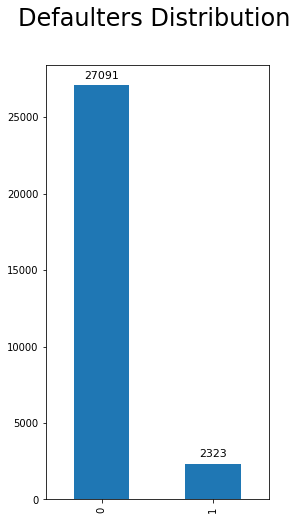

In [ ]:
fig = plt.figure(figsize=(4,8))
fig.suptitle('Defaulters Distribution', fontsize=24)
ax = cust[DEPENDENT_VARIABLE].value_counts().plot.bar()
for p in ax.patches: 
    ax.annotate("%0.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11,  xytext=(0, 10), textcoords='offset points')


## Univariate analysis

### Categorical Features


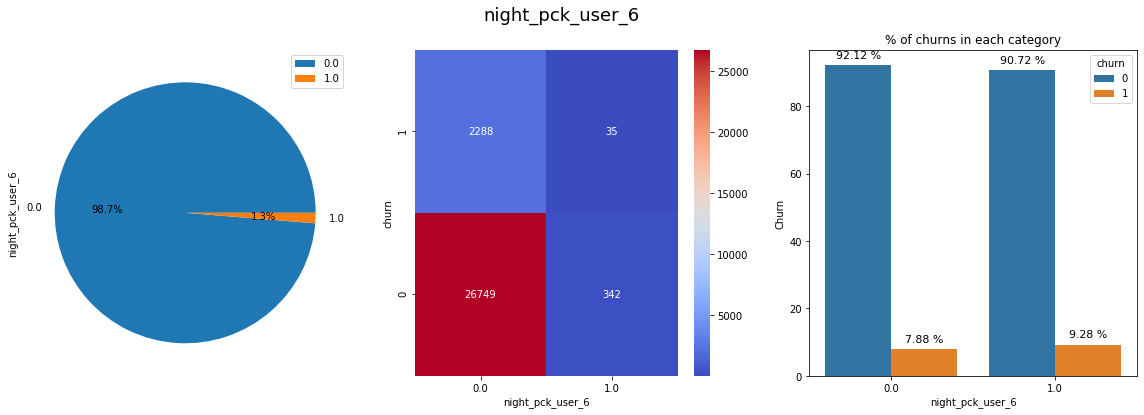

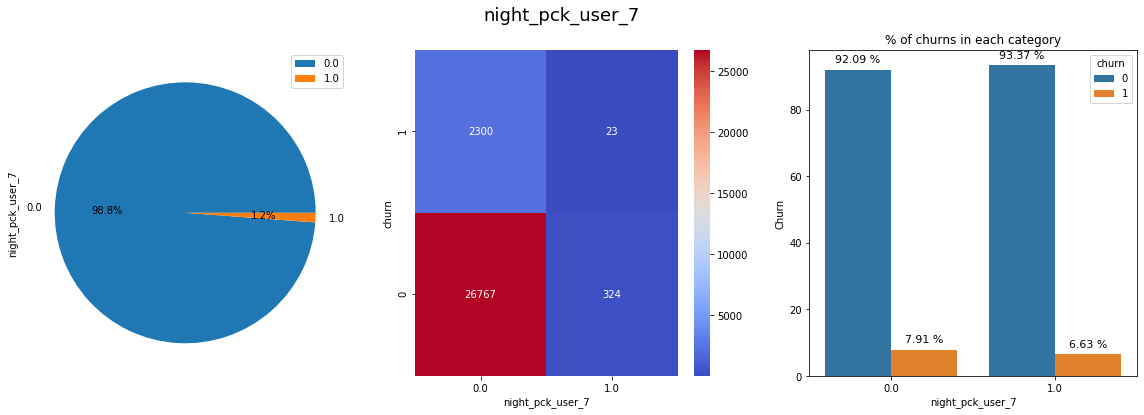

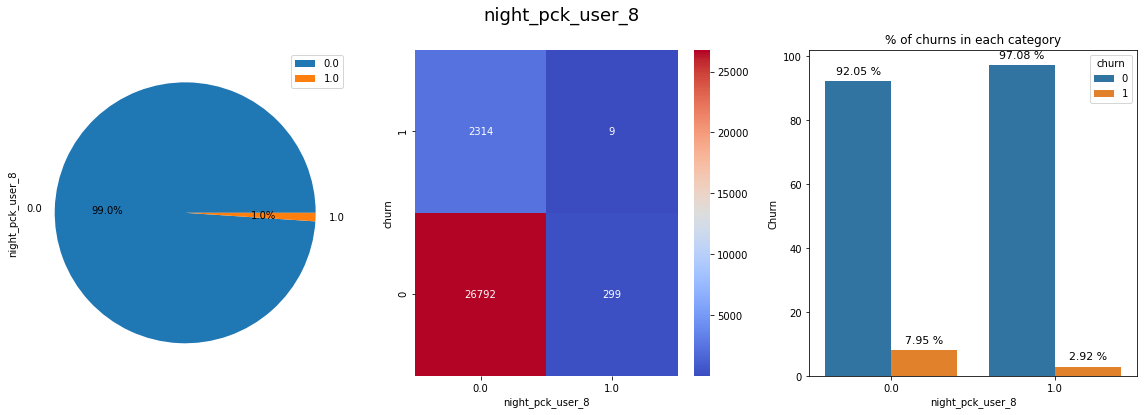

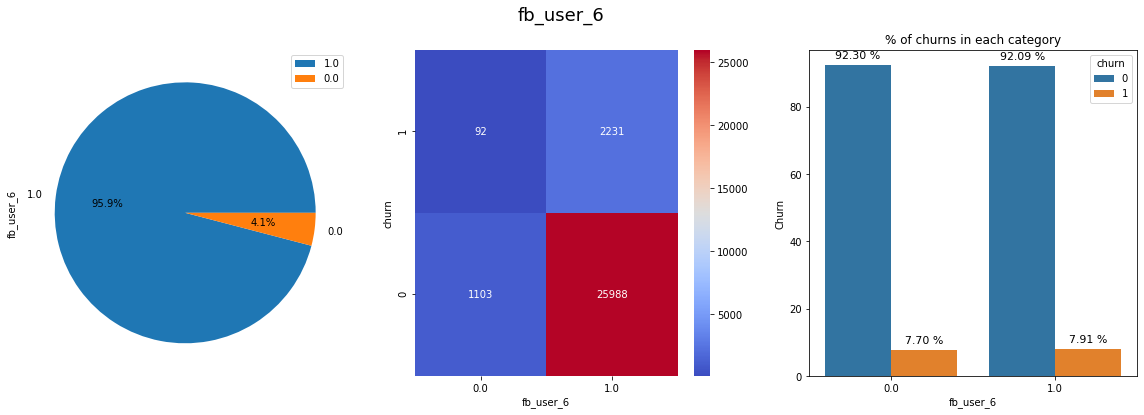

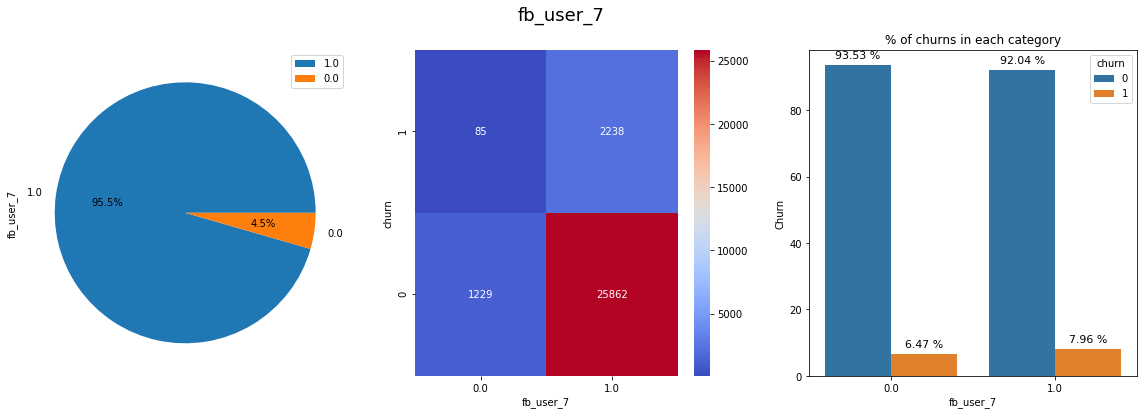

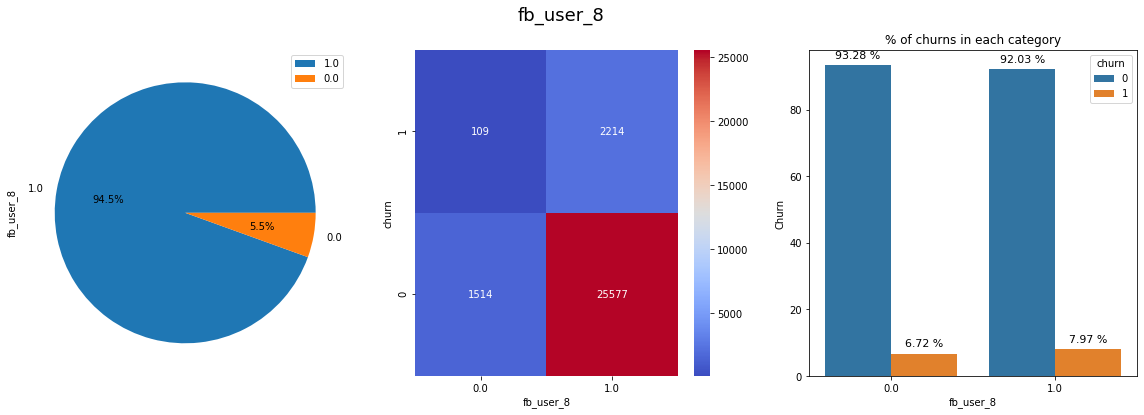

In [ ]:

    
# For each categorical variable, plot
# 1. Percentage distribution of each category - Univariate Analysis
# 2. Heatmap of each category against the target variable - Segmented Univariate Analysis
# 3. Grouped bar chart of each category against the target variable - Segmented Univariate Analysis
for col in BINARY_CATEGORICAL_VARIABLES:
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(col, fontsize=18)
    # Chart 1
    cust[col].value_counts().plot.pie(ax=ax[0], autopct="%1.1f%%")
    ax[0].legend()
    # Chart 2
    sns.heatmap(pd.crosstab(index=cust[DEPENDENT_VARIABLE], columns=cust[col]), ax=ax[1], cmap='coolwarm', annot=True, fmt='d') #, annot_kws=akws
    ax[1].set_ylim([0,2])
    # Chart 3 - grouped bar chart
    group_df = pd.DataFrame((cust.groupby([DEPENDENT_VARIABLE,col]).size()/cust.groupby([col]).size()*100).to_frame('count'))
    group_df.reset_index(inplace=True) 
    sns.barplot(x=group_df[col], y=group_df['count'], hue=group_df[DEPENDENT_VARIABLE], ax=ax[2])
    ax[2].set(xlabel=col, ylabel='Churn',title = '% of churns in each category') 

    #annotate axis = seaborn axis
    for p in ax[2].patches:
                 ax[2].annotate("%.2f %%" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11,  xytext=(0, 10),
                     textcoords='offset points')
        
    
    plt.yticks(rotation = 0)
    plt.show()

### Continuous Features - Univariate & Segmented Univariate Analysis

In [ ]:

# For each continuous variable, plot
# a. Distribution plot for each continuous variable - Univariate Analysis
# b. Distribution plot against the target variable - Segmented Univariate Analysis
for col in CONTINUOUS_VAR_TO_ANALYSE:
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle(col, fontsize=18)
    sns.distplot(cust[col], kde=False, ax=ax[0])
    for i in sorted(cust[DEPENDENT_VARIABLE].unique()):
        sns.distplot(cust[cust[DEPENDENT_VARIABLE] == i][col], kde=False, ax=ax[1], label=f'{DEPENDENT_VARIABLE} = {i}')
    ax[1].legend()

## Bivariate analysis

### Heat map/correlation matrix

In [ ]:
df = cust[CONTINUOUS_VAR_TO_ANALYSE + ['churn']]
corr = df.corr() 

In [ ]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [ ]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

In [ ]:
sns.pairplot(df)

<TODO> Insights:
    High correlation between 2 consecutive months (M6 & M7, M7 & M8).<br>
    Good correlation between alternate months (M6 & M8)<br>
--     Churn is negatively correlated to the calls made to the customer care (t2c). More calls to customer care implies more chances of churning.

# Derive new features

- Derive new features on average usage in good & action phase 
- Derive new feature on usage during action phase vs good phase

In [ ]:
# Method to create the derived features for the given column pattern
# 1. Get the average of good phase and action phase
# 2. Get the increase or decrease in the action phase as compared to the average in good phase
# 2. Drops the features from which the new columns were created to remove multicollinearity
def create_derived_avg_variables(pattern,col_prefix):
   # Create columns for the good phase & action phase
    gphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_6|_7]$', col)]
    aphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_8]$', col)]

    # Get average for good phase - Months 6 & 7
    good_phase_average = round((cust[gphase_cols].sum(axis=1))/2,2)
    cust[f'{col_prefix}_gphase_avg'] = good_phase_average

    # Get average for action phase - Month 8
    action_phase_average = round(cust[aphase_cols].sum(axis=1),2)
    cust[f'{col_prefix}_aphase_avg'] = action_phase_average 
    
    # Get the increase or decrease in the action phase as compared to the average in good phase
    # Difference value = (action phase average - good phase average)
    # Hypothesis: If the values are in negative, it implies that the variable has reduced in the action phase as compared to an average in the good phase - more likely to churn
      
    cust[f'{col_prefix}_gaphase_diff'] = round((action_phase_average - good_phase_average),2) 
    
    # Verify Values
    print('Sample data for cross-verification:')
    display(cust[gphase_cols + aphase_cols +[f'{col_prefix}_gphase_avg',f'{col_prefix}_aphase_avg',f'{col_prefix}_gaphase_diff']].tail())
    
    # Drop monthly arpu related columns after creating the derived variables
#    cust.drop(gphase_cols, axis=1, inplace=True)
#    cust.drop(aphase_cols, axis=1, inplace=True)

## Derive based on ARPU (Average Revenue Per User)

In [ ]:
create_derived_avg_variables('^arpu_.*','arpu')

## Derive based on total MOU (Minutes of Usage)

In [ ]:
create_derived_avg_variables('^total_og.*mou_','total_og_mou')
create_derived_avg_variables('^total_ic.*mou_','total_ic_mou')

## Derive based on volume of data usage

In [ ]:
create_derived_avg_variables('^vol_.*','vol')

## Derive based on outgoing calls

In [ ]:
# # Handle the outgoing calls to customer care separately
# create_derived_avg_variables('^loc_og_t2c_mou_','loc_t2c_og')
# create_derived_avg_variables('^loc_og_.*','loc_og')

## Derive based on incoming calls

In [ ]:
# create_derived_avg_variables('^loc_ic_.*','loc_ic')

In [ ]:
cust.shape

## Derive for the roaming calls

In [ ]:
create_derived_avg_variables('^roam_.*_mou_','roam_mou')

## Derive for recharge amount and drop the other rech columns

In [ ]:
cust['total_rech_data_amt_6'] = cust['total_rech_data_6']*cust['av_rech_amt_data_6']
cust['total_rech_data_amt_7'] = cust['total_rech_data_7']*cust['av_rech_amt_data_7']
cust['total_rech_data_amt_8'] = cust['total_rech_data_8']*cust['av_rech_amt_data_8']
cust.drop(['total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_data_8','av_rech_amt_data_8'],axis=1,inplace=True)

In [ ]:
create_derived_avg_variables('^total_rech_.*amt_','total_rech_amt')
create_derived_avg_variables('^count_rech_.*g_','count_rech')
create_derived_avg_variables('^total_rech_num_','total_rech_num')
create_derived_avg_variables('^max_rech_amt_','max_rech_amt')
create_derived_avg_variables('^max_rech_data_','max_rech_data')
create_derived_avg_variables('^last_day_rch_amt_','last_day_rch_amt')


## Derive for std incoming & outgoing

In [ ]:
# create_derived_avg_variables('^std_og_.*','std_og')
# create_derived_avg_variables('^std_ic_.*','std_ic')

In [ ]:
[col for col in cust.columns if re.search(f'rech', col)]

In [ ]:
cust.shape

In [ ]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

# Split data to independent & dependent variables

In [ ]:
X = cust.drop([DEPENDENT_VARIABLE],axis=1)
y = cust[DEPENDENT_VARIABLE]

# Handle class imbalance

In [ ]:
cust['churn'].value_counts()

<font color='green'>
    <b>Observations on class imbalance:</b><br>
- In the given dataset, churn vs non-churn is at 10%-90%. <br>
- This is a case of class imbalance where one class outnumbers the other. <br>
- We can apply some of the class imbalance techniques to address this issue and observe how the models behave <br>
- In this case study we shall use the oversampling & SMOTE techniques to address the class imbalance issue
</font>

## Oversampling

In [ ]:
# import library
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

# fit predictor and target variablex_ros, 
X_oversampled, y_oversampled = over_sampler.fit_resample(X,y)


print(f'''Shape of X before oversampling: {X.shape}
Shape of X after oversampling: {X_oversampled.shape}''')

print('\nBalance of positive and negative classes (%):')
y_oversampled.value_counts(normalize=True) * 100



## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
y_smote.value_counts(normalize=True) * 100

# Train-test split

## Train-test split on original data (without oversampling or SMOTE)

In [ ]:
# 70% of data used as train data and the remaining 30% as test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=100)

## Train-test split on oversampled data 


In [ ]:
# 70% of data used as train data and the remaining 30% as test data
X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test = train_test_split(X_oversampled,y_oversampled,test_size = 0.3, random_state=100)

## Train-test split on SMOTE data 


In [ ]:
# 70% of data used as train data and the remaining 30% as test data
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote,y_smote,test_size = 0.3, random_state=100)

# Feature Scaling

- After the train-test split, the features needs to be scaled as they are of different ranges.  
- Here we will use the MinMaxScaler to scale the data  
- All the 3 sets of data that has been created should be scaled.  
- Scaler should be fit on the training data. Only the transform method needs to be applied on the test data. (To ensure that the min & max values from the train data is used on the test data)

In [ ]:
cols_to_scale = X_train.columns

In [ ]:
# Scale the original dataset
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale] )

In [ ]:
# Scale the oversampled dataset
scaler_os = MinMaxScaler()
X_oversamfpled_train[cols_to_scale] = scaler_os.fit_transform(X_oversampled_train[cols_to_scale])
X_oversampled_test[cols_to_scale] = scaler_os.transform(X_oversampled_test[cols_to_scale])

In [ ]:
# Scale the SMOTE dataset
scaler_smote = MinMaxScaler()
X_smote_train[cols_to_scale] = scaler_smote.fit_transform(X_smote_train[cols_to_scale])
X_smote_test[cols_to_scale] = scaler_smote.transform(X_smote_test[cols_to_scale])

In [ ]:
X_train.describe()

# SET CONFIGURATIONS

## Set models to be run and compared

In [ ]:
# All supported models that can be run
ALL_SUPPORTED_MODELS = ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN_NAIVE_BAYES','GRADIENT_BOOST','XGB_CLASSIFIER','SVM_CLASSIFIER','KNN_CLASSIFIER','ADABOOST_CLASSIFIER','MLP_CLASSIFIER']

# Select models that needs to be run (Set to ALL_SUPPORTED_MODELS if all the models has to be run - RunTime could be high)
MODELS_TO_RUN =     ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN_NAIVE_BAYES','GRADIENT_BOOST','XGB_CLASSIFIER','ADABOOST_CLASSIFIER']

## Set the evaluation metric

In [ ]:
GRID_SEARCH_SCORING  = 'f1'# Metric used to identify the best model during hyperparameter tuning
EVALUATION_METRIC = 'F1 Score' #'Accuracy','AUROC','Sensitivity','Specificity','Precision'
SORT_ASCENDING = False

## Labels in the dataset

In [ ]:
labels = list(set(y_test))

## Grid/Random Search for Random Forest - Hyperparameter Tuning

In [ ]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 15],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [50, 100, 250, 500]
}

param_comb = 100

# Instantiate the grid search model - takes around 1hr 22m for PCA RF HPT
grid_search_rf = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = GRID_SEARCH_SCORING)

# Instantiate a random search model - to reduce the run-time
random_search_rf = RandomizedSearchCV(estimator=classifier_rf, param_distributions=params, n_iter=param_comb, scoring=GRID_SEARCH_SCORING, n_jobs=-1, cv=4, verbose=1, random_state=42)


## Random Search for XGBoost - Hyperparameter Tuning


In [ ]:
classifier_xgb = XGBClassifier(n_jobs = -1,objective = 'binary:logistic')

# A parameter grid for XGBoost
params = {
        'n_estimators' : [50, 100, 250, 500], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1, 2, 5, 10, 15]
        }

param_comb = 100 # to reduce run-time  

random_search_xgb = RandomizedSearchCV(classifier_xgb, param_distributions=params, n_iter=param_comb, scoring=GRID_SEARCH_SCORING, n_jobs=-1, cv=4, verbose=3, random_state=42)


# Helper Functions - Model Building

## Fit & Predict

In [ ]:
def model_fit_predict(model,X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_performance_measures(Y_test = y_test, Y_predict = y_pred, labels = labels)

## Print elapsed time in min & sec

In [ ]:
def print_elapsed_time(end_time,start_time):
    total_time = end_time - start_time
    print(f'Elapsed time: {total_time//60} min {round(total_time - total_time//60,3)} sec')
    
    

## Run models based on MODELS_TO_RUN list

In [ ]:
def run_all_models(X_train, X_test, y_train, y_test,model_type, model_result):
    
    start_time = time.time()
    
    # Logistic Regression
    if 'LOGISTRIC_REGRESSION' in MODELS_TO_RUN:
        print(f'\nRunning Model: Logistic Regression')
        model_start_time = time.time()
        model_result[f'{model_type}-LR'] = model_fit_predict(LogisticRegression(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Decision Tree Classifier
    if 'DECISION_TREE' in MODELS_TO_RUN:
        print(f'\nRunning Model: Decision Tree Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-DCART'] = model_fit_predict(DecisionTreeClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Random Forest Classifier 
    if 'RANDOM_FOREST' in MODELS_TO_RUN:
        print(f'\nRunning Model: Random Forest Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-RF'] = model_fit_predict(RandomForestClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Naive Bayes Classifier
    if 'GAUSSIAN_NAIVE_BAYES' in MODELS_TO_RUN:
        print(f'\nRunning Model: Naive Bayes Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-NB'] = model_fit_predict(GaussianNB(),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Gradient Boost Classifier
    if 'GRADIENT_BOOST' in MODELS_TO_RUN:
        print(f'\nRunning Model: Gradient Boost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-GB'] = model_fit_predict(GradientBoostingClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # XGBoost Classifier
    if 'XGB_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: XGBoost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-XGB'] = model_fit_predict(XGBClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    
    # SVM Classifier
    if 'SVM_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: SVM Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-SVC'] = model_fit_predict(SVC(probability=True,random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # K-Nearest Neighbors Classifier
    if 'KNN_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: K-Nearest Neighbors Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-KNN'] = model_fit_predict(KNeighborsClassifier(),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)

    # AdaBoost Classifier
    if 'ADABOOST_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: AdaBoost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-ABC'] = model_fit_predict(AdaBoostClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # MLP Classifier
    if 'MLP_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: MLP Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-MLP'] = model_fit_predict(MLPClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    print('\nCOMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!')
    print_elapsed_time(time.time(),start_time)
    
    return model_result.T

## Compute the evaluation metrics

In [ ]:
# Compute classification accuracy: percentage of correct predictions
def get_accuracy(Y_test, Y_predict):
    accuracy_score_value = accuracy_score(Y_test, Y_predict)
    return accuracy_score_value
        
# Compute the confusion metrics
def get_confusion_matrix(Y_test, Y_predict, labels):
    from sklearn.metrics import confusion_matrix

    conf_matrix = pd.DataFrame(confusion_matrix(Y_test, Y_predict, labels=labels), columns=labels, index=labels)
    conf_matrix_df = conf_matrix.add_prefix('Predicted ')
    conf_matrix_df.index = ['Actual ' + str(row_name) for row_name in conf_matrix_df.index]
    return conf_matrix_df, conf_matrix

# Compute null accuracy
def get_null_accuracy(Y_test, multiclass):
    # Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # Used as a reference as minimum accuracy to be achieved with the model
    null_accuracy = Y_test.value_counts().head(1) / len(Y_test)
    return null_accuracy.values[0]


def get_individual_values_from_confusion_matrix(conf_matrix):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    import numpy as np
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.values.sum() - (FP + FN + TP)

    return FP, FN, TP, TN


# Sensitivity, hit rate, recall, or true positive rate
def get_sensitivity(TP, FN):
    return TP / (TP + FN)


# Specificity or true negative rate
def get_specificity(TN, FP):
    return TN / (TN + FP)


# Precision or positive predictive value
def get_precision(TP, FP):
    return TP / (TP + FP)


# F1-SCORE
def get_f1_score(precision, sensitivity):
    return 2 * ((precision * sensitivity) / (precision + sensitivity))


# Negative predictive value
def get_negative_predictive_value(TN, FN):
    return TN / (TN + FN)


# Fall out or false positive rate
def get_false_positive_rate(FP, TN):
    return FP / (FP + TN)


# False negative rate
def get_false_negative_rate(FN, TP):
    return FN / (TP + FN)


# False discovery rate
def get_false_discovery_rate(FP, TP):
    return FP / (TP + FP)


# Log loss
def get_log_loss(y_true, y_pred_proba):
    from sklearn.metrics import log_loss
    return log_loss(y_true, y_pred_proba, eps=1e-15)

# AUROC score
def get_roc_auc_score(Y_test,Y_predict):
    return roc_auc_score(Y_test,Y_predict)

def get_performance_measures(Y_test, Y_predict, labels):
    conf_matrix_df, conf_matrix = get_confusion_matrix(Y_test, Y_predict, labels)
    FP, FN, TP, TN = get_individual_values_from_confusion_matrix(conf_matrix)
    df = pd.DataFrame({
        'Accuracy': get_accuracy(Y_test,Y_predict),
        'Null Accuracy': get_null_accuracy(Y_test,Y_predict),
        'AUROC':get_roc_auc_score(Y_test,Y_predict),
        'Sensitivity': get_sensitivity(TP, FN),
        'Specificity': get_specificity(TN, FP),
        'Precision': get_precision(TP, FP),
        'F1 Score': get_f1_score(get_precision(TP, FP), get_sensitivity(TP, FN)),
        'Negative Predictive Value': get_negative_predictive_value(TN, FN),
        'False Positive Rate': get_false_positive_rate(FP, TN),
        'False Negative Rate': get_false_negative_rate(FN, TP),
        'False Discovery Rate': get_false_discovery_rate(FP, TP),
    })#.T.add_prefix('Class ')
    # Creates metrics for each label. Return details of only class 1 (customer churn)
    return (df.loc[1]*100).round(3)



# Model building 1 - PCA

## PCA for dimensionality reduction

In [ ]:
pca = PCA(random_state=42)
pca.fit(X_train)
pca.components_

In [ ]:
pca.explained_variance_ratio_

In [ ]:
# plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.bar(range(1,31), pca.explained_variance_ratio_[1:31])

In [ ]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

# Making the scree plot
plt.plot(range(1,len(var_cumu)+1), var_cumu)

In [ ]:
pd.DataFrame(var_cumu).head(30)

<font color='green'>
<b>PCA Inference:</b> <br>
- 94% of the variance is explained by the first 20 Principal Components <br>
- We can try running models with 20 components and check how they perform
</font>

## Create PCA datasets

In [ ]:
num_pcs = 20

In [ ]:
# Get the top 20 principal components 
pcs = IncrementalPCA(n_components=num_pcs)

In [ ]:
# Utility method to create the new principal component datasets on the train & test data
def create_pca_data(train,test):
    train_pca = pd.DataFrame(pcs.fit_transform(train)).add_prefix('PC')
    # Index is lost after PCA as it works on Numpy arrays. 
    # Ref: https://github.com/scikit-learn/scikit-learn/issues/8238
    train_pca.index = train.index
    print(f'Train PCA data shape:{train_pca.shape}')
    display(train_pca.head(3))

    test_pca = pd.DataFrame(pcs.transform(test)).add_prefix('PC')
    test_pca.index = test.index
    print(f'Test PCA data shape:{test_pca.shape}')
    display(test_pca.head(3))
    
    
    
    return train_pca, test_pca
    

In [ ]:
# Create PCA dataset for the original dataset
X_train_pca, X_test_pca = create_pca_data(X_train,X_test)

In [ ]:
# Create PCA dataset for the oversampled dataset
X_oversampled_train_pca, X_oversampled_test_pca = create_pca_data(X_oversampled_train,X_oversampled_test)

In [ ]:
# Create PCA dataset for the SMOTE dataset
X_smote_train_pca, X_smote_test_pca = create_pca_data(X_smote_train,X_smote_test)

## Check for multicollinearity - PCA

Verify that the features (Principal Components) created from PCA are not correlated to each other

In [ ]:
corrmat = np.corrcoef(X_train_pca.transpose())
corrmat.shape

In [ ]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

In [ ]:
# Plotting the data of PC0 vs PC1
df_final = pd.concat([X_train_pca, y_train], axis=1)
sns.scatterplot(data=df_final, x="PC0", y="PC1",hue="churn")


## Model building - PCA

In [ ]:
model_result_pca = pd.DataFrame()

### Default Model Building

In [ ]:
# Default model run
run_all_models(X_train_pca, X_test_pca, y_train, y_test,'PCA',model_result_pca)
model_result_pca
#model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

In [ ]:
model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

### Model building with HPT

In [ ]:
model_type_pca_hpt = 'PCA-HPT'

#### HPT for Random Forest

In [ ]:
# %%time
grid_search_rf.fit(X_train_pca,y_train)
rf_grid_best_est = grid_search_rf.best_estimator_

In [ ]:
# %%time
# random_search_rf.fit(X_train_pca,y_train)
# rf_best_est = random_search_rf.best_estimator_

In [ ]:
model_result_pca[f'{model_type_pca_hpt}-RF'] = model_fit_predict(rf_grid_best_est,X_train_pca, X_test_pca, y_train, y_test)

#### HPT for XGBoost

In [ ]:
%%time
random_search_xgb.fit(X_train_pca,y_train)
xgb_best_est = random_search_xgb.best_estimator_

In [ ]:
model_result_pca[f'{model_type_pca_hpt}-XGB'] = model_fit_predict(xgb_best_est,X_train_pca, X_test_pca, y_train, y_test)

### Model on oversampled data

In [ ]:
run_all_models(X_oversampled_train_pca, X_oversampled_test_pca, y_oversampled_train, y_oversampled_test,'PCA - Oversampled',model_result_pca)
model_result_pca.T

### Model on SMOTE data

In [ ]:
run_all_models(X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test,'PCA - SMOTE',model_result_pca)
model_result_pca.T

### Model on (SMOTE + HPT)

In [ ]:
model_type_pca_smotehpt = 'PCA-SMOTE+HPT'

#### SMOTE+HPT for Random Forest

In [ ]:
%%time
grid_search_rf.fit(X_smote_train_pca,y_smote_train)
rf_grid_smote_best_est = grid_search_rf.best_estimator_

In [ ]:
# %%time

# random_search_rf.fit(X_smote_train_pca,y_smote_train)
# rf_smote_best_est = random_search_rf.best_estimator_


In [ ]:
model_result_pca[f'{model_type_pca_smotehpt}-RF'] = model_fit_predict(rf_grid_smote_best_est,X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test)

####  SMOTE+HPT for XGBoost

In [ ]:
model_result_pca.T

In [ ]:
%%time
random_search_xgb.fit(X_smote_train_pca,y_smote_train)
xgb_smote_best_est = random_search_xgb.best_estimator_

In [ ]:
model_result_pca[f'{model_type_pca_smotehpt}-XGB'] = model_fit_predict(xgb_smote_best_est,X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test)

## Summary from all models

In [ ]:
model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

<font color = 'green'>
    <b>Insights from the summary table - PCA</b><br>
- Models with oversampled data & smote data perform better than the models without any class imbalance treatement <br> 
- Models run on oversampled data perform better than models run on SMOTE data<br>
- Random Forest performs well with this data<br>
- While running with the original dataset (without addressing the class imbalance), the hyperparameter tuned model with XGB outperforms the other models.<br>
</font>

# Model building 2 - without PCA

## Build  Models

In [ ]:
model_result_featimp = pd.DataFrame()

### Default model building

In [ ]:
# Default model run - Feature Importance (FI)
run_all_models(X_train, X_test, y_train, y_test,'FI', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

### Model with HPT

In [ ]:
model_type_FI_hpt = 'FI-HPT'

#### HPT for Random Forest

In [ ]:
%%time
grid_search_rf.fit(X_train,y_train)
rf_fi_grid_best_est = grid_search_rf.best_estimator_

In [ ]:
# %%time
# random_search_rf.fit(X_train,y_train)
# rf_fi_best_est = random_search_rf.best_estimator_

In [ ]:
model_result_featimp[f'{model_type_FI_hpt}-RF'] = model_fit_predict(rf_fi_grid_best_est,X_train, X_test, y_train, y_test)

#### HPT for XGBoost

In [ ]:
%%time
random_search_xgb.fit(X_train,y_train)
xgb_fi_best_est = random_search_xgb.best_estimator_

In [ ]:
model_result_featimp[f'{model_type_FI_hpt}-XGB'] = model_fit_predict(xgb_fi_best_est,X_train, X_test, y_train, y_test)

### Model with Oversampled Data

In [ ]:
run_all_models(X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test,'FI - Oversampled', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

### Model with SMOTE Data

In [ ]:
run_all_models(X_smote_train, X_smote_test, y_smote_train, y_smote_test,'FI - SMOTE', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

### Model with SMOTE+HPT

In [ ]:
model_type_FI_smotehpt = 'FI-SMOTE+HPT'

#### HPT for Random Forest

In [ ]:
%%time
grid_search_rf.fit(X_smote_train_pca,y_smote_train)
rf_grid_fi_smote_best_est = grid_search_rf.best_estimator_

In [ ]:
# %%time

# random_search_rf.fit(X_smote_train,y_smote_train)
# rf_fi_smote_best_est = random_search_rf.best_estimator_


In [ ]:
model_result_featimp[f'{model_type_FI_smotehpt}-RF'] = model_fit_predict(rf_grid_fi_smote_best_est,X_smote_train, X_smote_test, y_smote_train, y_smote_test)

#### HPT for XGBoost

In [ ]:
%%time
random_search_xgb.fit(X_smote_train,y_smote_train)
xgb_fi_smote_best_est = random_search_xgb.best_estimator_

In [ ]:
model_result_featimp[f'{model_type_FI_smotehpt}-XGB'] = model_fit_predict(xgb_fi_smote_best_est,X_smote_train, X_smote_test, y_smote_train, y_smote_test)

### Summary from all the Models

Goal: Evaluate the models using appropriate evaluation metrics. Note that is is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

In [ ]:

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

<font color = 'green'>
<b>Insights from the summary table</b><br>
- Since it is important to identify churners than non-churners, 
- Comparing the model performances in the above summary table, it is clear that the model performs better when the class imbalance issue is addressed.<br>
- Models run on oversampled data perform better than models run on SMOTE data<br>
- Random Forest performs well with this data<br>
- While running with the original dataset (without addressing the class imbalance), the hyperparameter tuned model with XGB outperforms the other models.<br>
</font>

## Best Model for Feature Importance

### Feature Importance with Random Forest & XGB models

In [ ]:
print(f'Important features from Random Forest HPT model')

imp_rf_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_grid_fi_best_est.feature_importances_
})
imp_rf_df.sort_values(by="Imp", ascending=False)

In [ ]:
print(f'Important features from XGB HPT model')

imp_xgb_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": xgb_fi_best_est.feature_importances_
})
imp_xgb_df.sort_values(by="Imp", ascending=False)

In [ ]:
print(f'Important features from RF - oversampled model')
model_rf_oversampled = RandomForestClassifier(random_state=42).fit(X_oversampled_train, y_oversampled_train)

imp_rf_oversampled_df = pd.DataFrame({
    "Varname": X_oversampled_train.columns,
    "Imp": model_rf_oversampled.feature_importances_
})
imp_rf_oversampled_df.sort_values(by="Imp", ascending=False)

## Correlation matrix with the target for the important features

In [ ]:
imp_features = ['total_rech_amt_gaphase_avg','fb_user_8','total_mou_gaphase_avg','arpu_gaphase_avg','loc_ic_gaphase_avg','last_rech_num_days']

In [ ]:
df = cust[imp_features + ['churn']]
corr = df.corr() 

In [ ]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [ ]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

# Insights

## Best Model - with PCA

Finally, choose a model based on some evaluation metric.

<font color='green'>
<b>Approach:</b> <br>
- Models were created with 3 different types of data: <br>
-- Input Data<br>
-- Oversampled Data<br>
-- SMOTE Data<br>
- Based on the F1-Score and AUROC, we can notice that the models created with the oversampled data before the best.<br>
- <br>
- The models with oversampled data perform better than the <br>
</font>

## Important features

After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

## Conclusion - recommendation to manage customer churn

Finally, recommend strategies to manage customer churn based on your observations.